# Image Captioning on the MS COCO Dataset using Autoencoders and Attention

The Image Captioning is carried out on the ARMBench Dataset here using Autoencoders and Nearest Neighbours

The necessary libraries are imported

In [2]:
import pandas as pd #Import necessary libraries
import numpy as np
import json
import cv2
import string
import nltk
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from keras.models import Model
from keras.losses import mean_squared_error
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [3]:
from sklearn.utils import resample
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

C:\Users\sahre\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sahre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
BASE_PATH = 'D:/Down/cocodataset' # Set the base path to the location where the dataset is present

## Data Preprocessing

Here, the first 50000 images are used and image paths are added to the dataframe.

In [6]:
with open(f'{BASE_PATH}/annotations_trainval2017/annotations/captions_train2017.json', 'r') as f: #load annotations
    data = json.load(f)
    data = data['annotations']

img_cap_pairs = []

for sample in data:
    img_id = sample['image_id']
    img_name = '%012d.jpg' % img_id
    img_cap_pairs.append([img_id, img_name, sample['caption']])

captions = pd.DataFrame(img_cap_pairs, columns=['id', 'image', 'caption']) #create df with the images, ids and captions
captions['image'] = captions['image'].apply(lambda x: f'{BASE_PATH}/train2017/train2017/{x}')

captions = captions.sample(50000)
captions = captions.reset_index(drop=True)
captions.rename(columns={'id': 'image_id'}, inplace=True)
print(captions.head())

   image_id                                              image  \
0    384049  D:/Down/cocodataset/train2017/train2017/000000...   
1     38022  D:/Down/cocodataset/train2017/train2017/000000...   
2    180623  D:/Down/cocodataset/train2017/train2017/000000...   
3    365206  D:/Down/cocodataset/train2017/train2017/000000...   
4    181554  D:/Down/cocodataset/train2017/train2017/000000...   

                                             caption  
0  A young girl poses by a graphic of paper parasols  
1    A green double decker bus called "Green Rovers"  
2    A stone building with a large clock on the top.  
3      A large group of people standing in a street.  
4  The man is outside playing Frisbee with his dog.   


In [17]:
avg_length = df['caption'].apply(len).mean() #average caption length

In [18]:
avg_length

52.91845

In [19]:
avg_word_count = df['caption'].apply(lambda x: len(x.split())).mean() #average word count

In [21]:
avg_word_count

10.50495

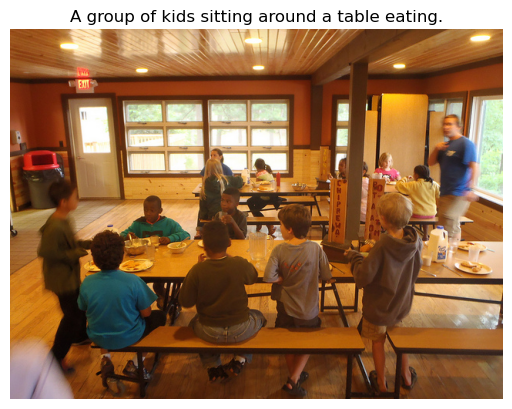

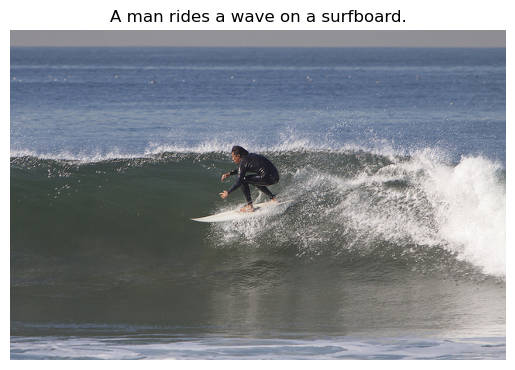

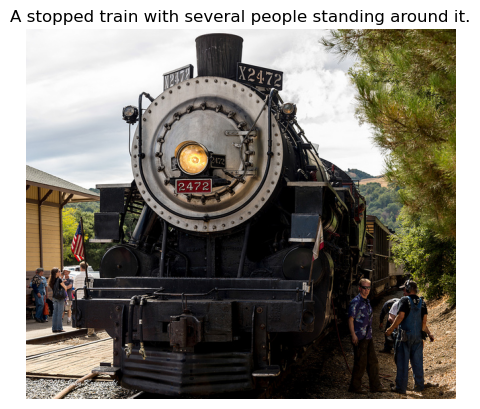

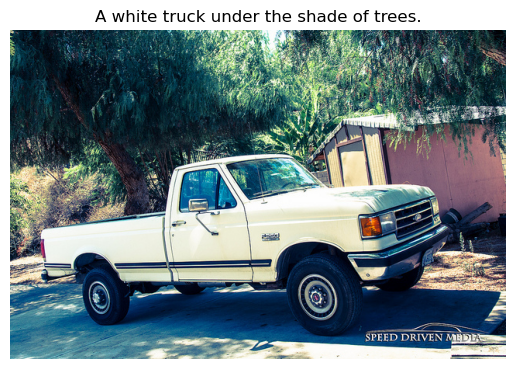

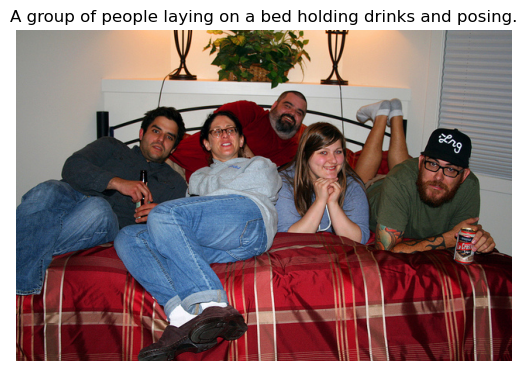

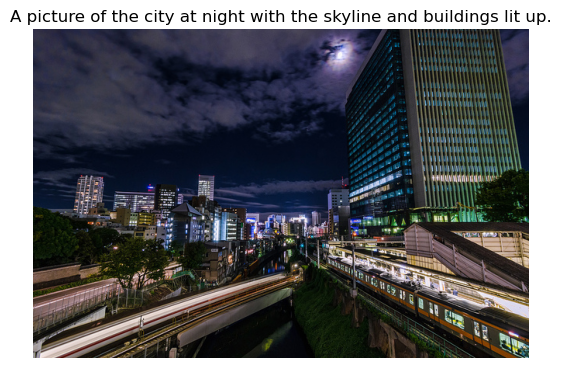

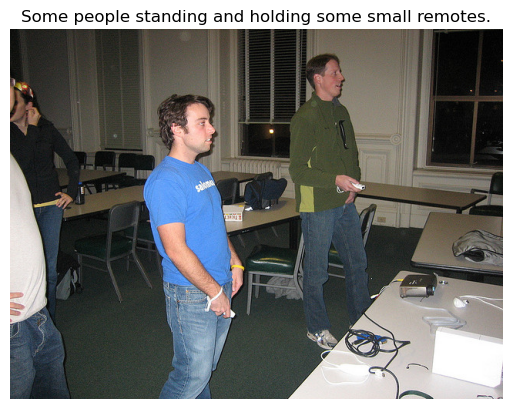

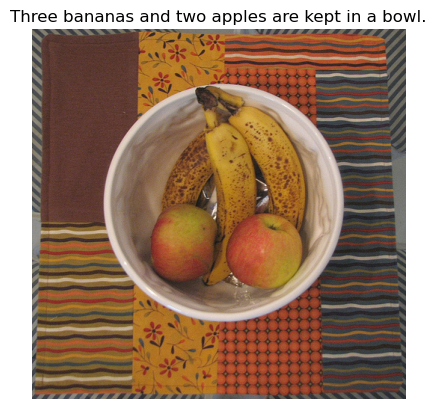

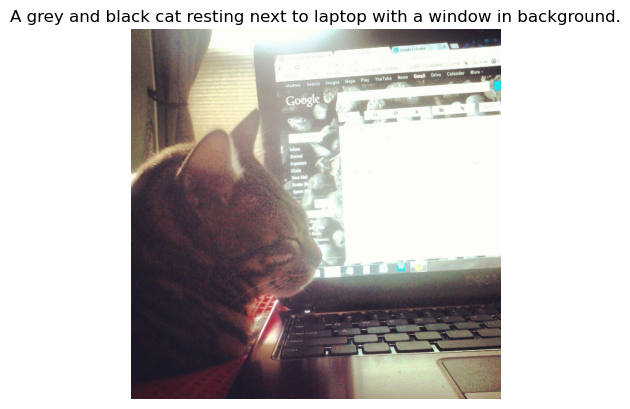

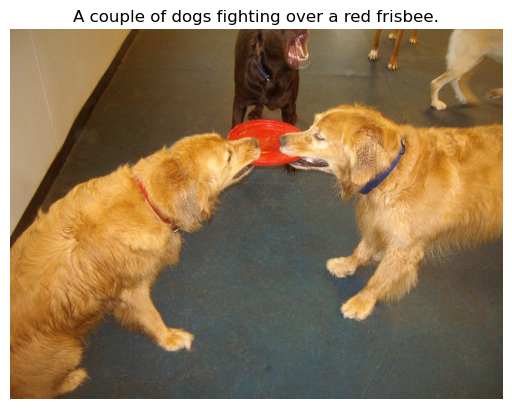

In [7]:
def display_image_with_caption(image_path, caption):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

# Visualize 10 random images and their captions
for i in range(10):
    index = captions.sample().index[0]
    image_path = captions.loc[index, 'image']
    caption = captions.loc[index, 'caption']
    display_image_with_caption(image_path, caption)


In [8]:

with open('D:/Down/cocodataset/annotations_trainval2017/annotations/instances_train2017.json', 'r') as file:
    data = json.load(file)

In [9]:

with open(f'{BASE_PATH}/annotations_trainval2017/annotations/instances_train2017.json', 'r') as f:
    data = json.load(f)

data['categories'] = list(data['categories']) #data cleaning
category_dict = {category['id']: {'name': category['name'], 'supercategory': category['supercategory']} for category in data['categories']}
data_list = []
for item_id, item_info in enumerate(data['annotations']):
    item_dict = {
        'image_id': item_info['image_id'],
        'category_id': item_info['category_id'],
        'id': item_info['id'],
        'name': category_dict[item_info['category_id']]['name'],  
        'supercategory': category_dict[item_info['category_id']]['supercategory']  
    }
    data_list.append(item_dict)

df = pd.DataFrame(data_list)

In [10]:
merged_df = captions.merge(df, on='image_id', how='inner')

In [11]:
import pandas as pd

unique_categories = merged_df['name'].unique()

# Print the unique supercategories
print("Unique Categories in the 'name' column:")
print(unique_categories)



Unique Categories in the 'name' column:
['person' 'umbrella' 'bus' 'clock' 'car' 'dining table' 'backpack'
 'handbag' 'tie' 'chair' 'dog' 'frisbee' 'skis' 'sports ball' 'toilet'
 'parking meter' 'donut' 'cup' 'fire hydrant' 'traffic light' 'cat'
 'skateboard' 'bottle' 'couch' 'book' 'bed' 'banana' 'remote' 'bear'
 'truck' 'fork' 'knife' 'pizza' 'potted plant' 'giraffe' 'apple'
 'elephant' 'bicycle' 'baseball glove' 'suitcase' 'carrot' 'cake'
 'keyboard' 'stop sign' 'surfboard' 'bowl' 'bird' 'bench' 'train'
 'teddy bear' 'vase' 'orange' 'kite' 'tv' 'mouse' 'broccoli' 'wine glass'
 'motorcycle' 'laptop' 'spoon' 'cell phone' 'sheep' 'tennis racket'
 'toothbrush' 'baseball bat' 'sandwich' 'boat' 'sink' 'horse' 'microwave'
 'oven' 'snowboard' 'zebra' 'airplane' 'hot dog' 'refrigerator' 'cow'
 'scissors' 'hair drier' 'toaster']


The Supercategory Counts are printed for the Top 10 Most Frequently Occurring categories.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
merged_df = merged_df.drop_duplicates(subset=['caption'])

category_freq = merged_df['supercategory'].value_counts() #Dominant Supercategory Counts

top_10_categories = category_freq.nlargest(10).index.tolist()

print(category_freq[top_10_categories])




supercategory
person        9167
animal        8850
vehicle       8211
furniture     5185
kitchen       3409
electronic    2653
sports        2442
food          2323
indoor        2229
accessory     2177
Name: count, dtype: int64


2000 Samples are selected from all 10 categories and category distibution is plotted on a bar chart.

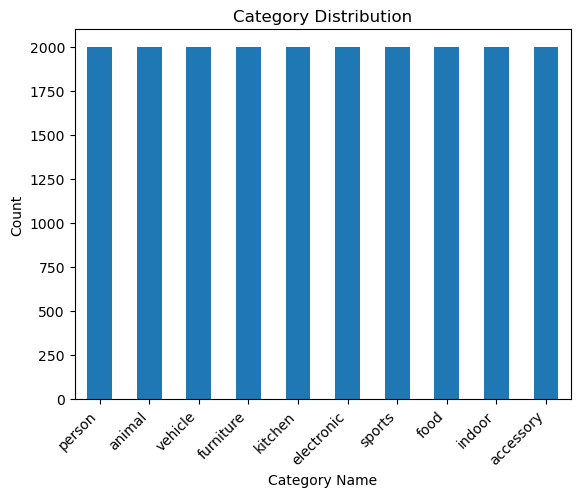

In [14]:

df = pd.DataFrame()

for supercategory in top_10_categories:
    category_data = merged_df[merged_df['supercategory'] == supercategory].head(2000) 
    df = pd.concat([df, category_data])

df.reset_index(drop=True, inplace=True)

category_counts = df['supercategory'].value_counts()  #Plotting the value counts


category_counts.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Category Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.show()

In [15]:

df.drop_duplicates(inplace=True)


df.reset_index(drop=True, inplace=True)


In [19]:

def preprocess_image(image_path, target_size=(64, 64)): #Data preprocessing
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise Exception(f"Failed to read the image at path: {image_path}")

        if len(img.shape) == 2:
            img = gray2rgb(img)
        img_resized = resize(img, target_size, mode='reflect')
        return img_resized
    except Exception as e:
        print(f"Error processing image: {e}")
        return None


In [20]:
def preprocess_caption(caption): #Caption preprocessing
    # Lowercase
    caption = caption.lower()
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and lemmatize
    words = caption.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a caption and return
    return ' '.join(words)

In [21]:
from sklearn.model_selection import train_test_split

df_train_temp, df_temp = train_test_split(df, test_size=0.2, random_state=42) #Data splitting

df_validation, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
df_test2 = df_test.copy()
df_validation2 = df_validation.copy()

def preprocess_data(df):
    df['image'] = df['image'].apply(preprocess_image)
    df['caption_preprocessed'] = df['caption'].apply(preprocess_caption)
    df = df.dropna(subset=['image'])
    return np.array(df['image'].tolist()), df

x_train, df_train = preprocess_data(df_train_temp)
x_validation, df_validation = preprocess_data(df_validation)
x_test, df_test = preprocess_data(df_test)

## Autoencoder + Attention

The autoencoder architecture (encoder and decoder) along with Attention Mechanism is defined and run for 100 epochs with a batch size of 128

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Dense, Reshape
from tensorflow.keras.layers import multiply 

input_img = Input(shape=(64, 64, 3)) #encoder architecture

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Spatial attention mechanism
def spatial_attention(input_feature):
    kernel_size = 7  # You can change the kernel size
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    dense = Dense(128, activation='relu')(concat)
    dense = Dense(8, activation='relu')(dense)
    dense = Reshape((1, 1, 8))(dense)

    attention = multiply([input_feature, dense])  
    return attention

encoded_with_attention = spatial_attention(encoded)


In [24]:
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_with_attention) #decoder architecture
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, shuffle=True) #training the model


Epoch 1/100
125/125 [==============================] - 48s 370ms/step - loss: 0.6084
Epoch 2/100
125/125 [==============================] - 50s 402ms/step - loss: 0.5547
Epoch 3/100
125/125 [==============================] - 49s 391ms/step - loss: 0.5496
Epoch 4/100
125/125 [==============================] - 48s 387ms/step - loss: 0.5475
Epoch 5/100
125/125 [==============================] - 47s 375ms/step - loss: 0.5460
Epoch 6/100
125/125 [==============================] - 47s 379ms/step - loss: 0.5448
Epoch 7/100
125/125 [==============================] - 46s 366ms/step - loss: 0.5440
Epoch 8/100
125/125 [==============================] - 47s 373ms/step - loss: 0.5433
Epoch 9/100
125/125 [==============================] - 47s 377ms/step - loss: 0.5430
Epoch 10/100
125/125 [==============================] - 46s 372ms/step - loss: 0.5425
Epoch 11/100
125/125 [==============================] - 47s 374ms/step - loss: 0.5422
Epoch 12/100
125/125 [==============================] - 46s 371

In [26]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_1').output) 
x_train_encoded = encoder.predict(x_train) #encoded images
x_test_encoded = encoder.predict(x_test)

63/63 [==============================] - 1s 10ms/step


1/1 [==============================] - 0s 114ms/step


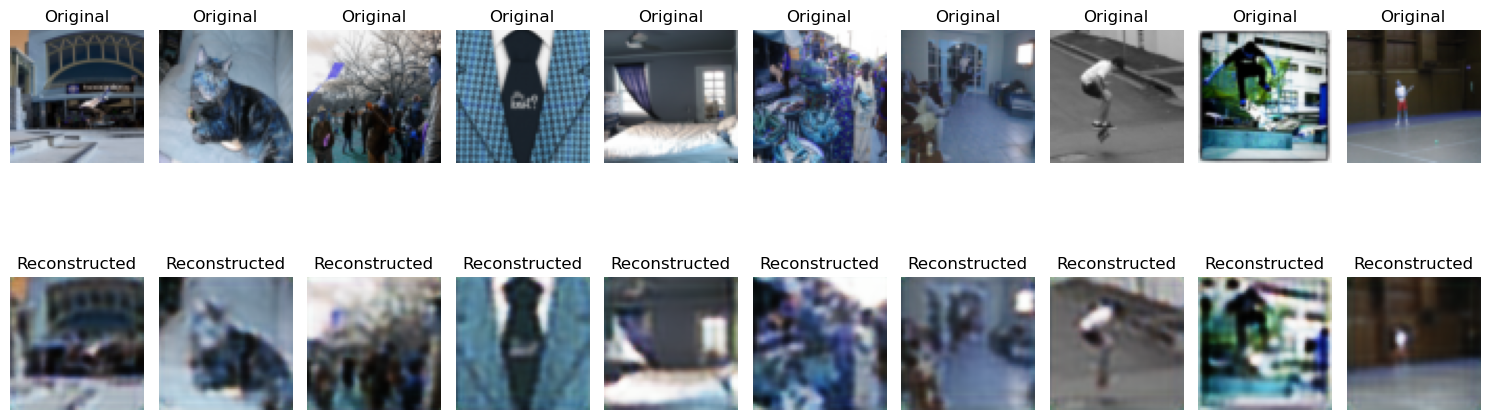

In [92]:
#visualising the original and reconstructed images
num_images_to_visualize = 10
random_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
images_to_visualize = x_test[random_indices]


reconstructed_images = autoencoder.predict(images_to_visualize)


plt.figure(figsize=(15, 6))
for i in range(num_images_to_visualize):

    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(images_to_visualize[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, num_images_to_visualize + i + 1)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()

The Reconstruction Loss is calculated using the Mean Squared Error Loss.

In [93]:

reconstructed_images = autoencoder.predict(x_test)

# Calculate the Mean Squared Error (MSE) loss
mse_loss = mean_squared_error(x_test, reconstructed_images)

average_mse_loss = np.mean(mse_loss)
print("Average MSE Loss:", average_mse_loss)

63/63 [==============================] - 2s 30ms/step
Average MSE Loss: 0.0042708754


## Nearest Neighbours

The encoded images are flattened and fitted in the Nearest Neighbor M

In [31]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1) #fitting the encoded images to Nearest Neighbours


neighbors = NearestNeighbors(n_neighbors=5)
neighbors.fit(x_train_flat)




Here, a random image is visualised and the true and nearest neighbour caption is printed.

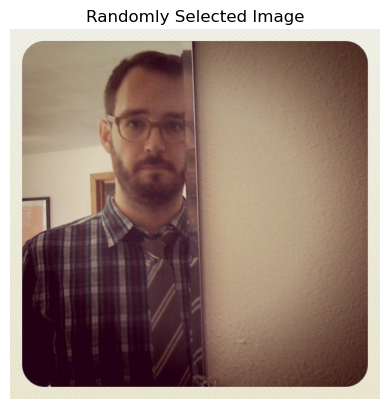

True caption for the randomly selected image: A man that is looking in a mirror.
Generated caption for the randomly selected image: a grown standing in front of the door wearing a pair of glasses 


In [99]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image") #visualising a random image
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0]  # Predicting the caption of the closest neighbor of the image


true_caption = df_test.iloc[random_index]['caption'] 

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")


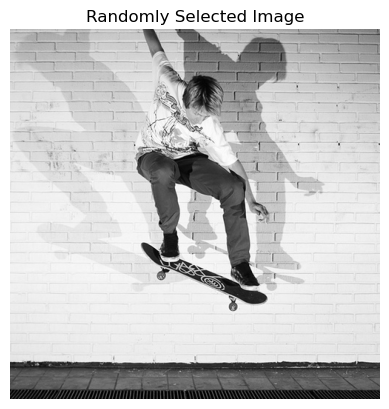

True caption for the randomly selected image: A young man jumping a skateboard into the air in front of a brick wall.
Generated caption for the randomly selected image: A young skateboarder becomes airborne while his shadows display on a brick wall.


In [104]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

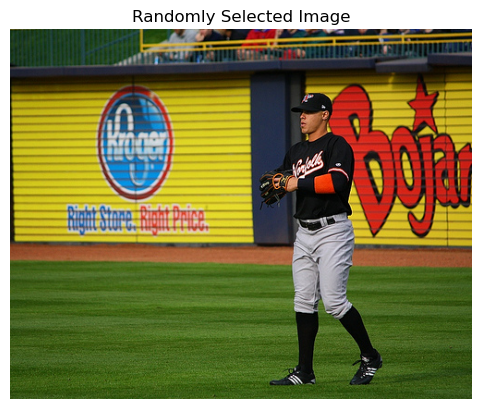

True caption for the randomly selected image: Outfielder with hand in baseball glove walking across field
Generated caption for the randomly selected image: A pitch being thrown to the batter at a baseball game.


In [105]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

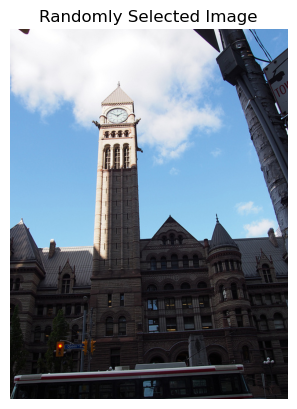

True caption for the randomly selected image: a building attached to a tall clock tower
Generated caption for the randomly selected image: A large tall tower with a clock on the top.


In [106]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

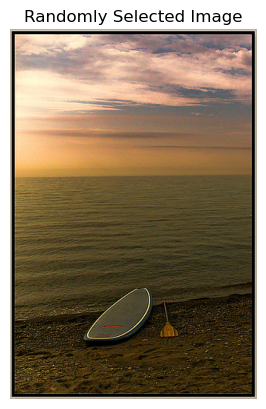

True caption for the randomly selected image: A board and paddle on the edge of the ocean.
Generated caption for the randomly selected image: The surfboard and paddle lay on the beach.


In [113]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

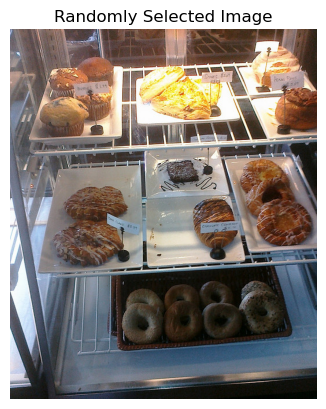

True caption for the randomly selected image: A display case with various trays of doughnuts in it.
Generated caption for the randomly selected image: A bakery glass display case with donuts and assorted pastries.


In [118]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

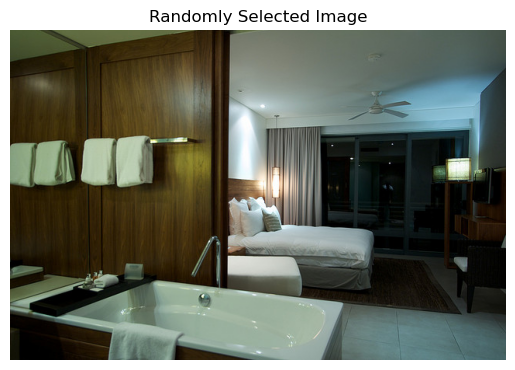

True caption for the randomly selected image: A hotel room with a white bed and tub.
Generated caption for the randomly selected image: there is a white toilet with the seat up here


In [128]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

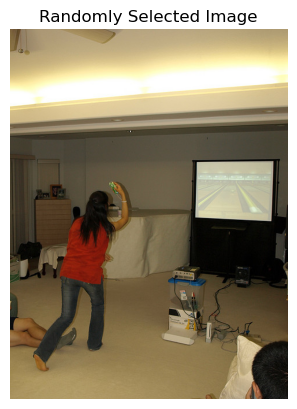

True caption for the randomly selected image: a woman plays a video game in a living room 
Generated caption for the randomly selected image: A truck that is driving down the street near the grass.


In [129]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

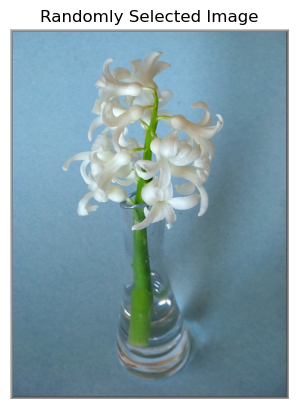

True caption for the randomly selected image: A white flower in a small clear vase.
Generated caption for the randomly selected image: Ferry with passengers riding on the water with a city in the background.


In [130]:

random_index = np.random.randint(0, len(df_test))


image_path = df_test2.iloc[random_index]['image']


random_image = Image.open(image_path)
plt.imshow(random_image)
plt.title("Randomly Selected Image")
plt.axis('off') 
plt.show()
random_image = x_test[random_index]


random_image_flat = random_image.reshape(1, -1)


distances, indices = neighbors.kneighbors(random_image_flat)


neighbor_captions = df_train.iloc[indices[0]]['caption'].values


generated_caption = neighbor_captions[0] 


true_caption = df_test.iloc[random_index]['caption']

print(f"True caption for the randomly selected image: {true_caption}")
print(f"Generated caption for the randomly selected image: {generated_caption}")

Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Test Set.

In [120]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_test):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['caption'].values
    true_caption = df_test.iloc[i]['caption']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_test)
average_meteor_score_average = total_meteor_score_average / len(x_test)
average_meteor_score_median = total_meteor_score_median / len(x_test)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")


Average METEOR Score using Closest Neighbor: 0.18575131963470481
Average METEOR Score using Average Distance: 0.12686643575861065
Average METEOR Score using Median Distance: 0.12504575218475691


Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set.

In [144]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['caption'].values
    true_caption = df_validation.iloc[i]['caption']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.18341822851913642
Average METEOR Score using Average Distance: 0.12512910729874524
Average METEOR Score using Median Distance: 0.12676326780511726


## Hyperparameter Tuning

Hyperparameter Tuning is carried out to choose the most optimal distance metric.

In [32]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
# Define the metrics
metrics_to_test = ['minkowski', 'manhattan', 'euclidean', 'cosine'] #distance metrics to test


n_neighbors_fixed = 5

best_score = float('inf')
best_metric = None


for metric in metrics_to_test:
    neighbors = NearestNeighbors(n_neighbors=n_neighbors_fixed, metric=metric)
    neighbors.fit(x_train_flat)
    
    distances, _ = neighbors.kneighbors(x_train_flat, n_neighbors=1)
    mean_distance = distances.mean()
    
    if mean_distance < best_score:
        best_score = mean_distance
        best_metric = metric

print("Best metric:", best_metric)


Best metric: manhattan


The encoded images are fitted again using the manhattan distance as the distance metric.

In [33]:
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


x_train_flat = x_train.reshape(x_train_encoded.shape[0], -1)


neighbors = NearestNeighbors(n_neighbors=5, metric = "manhattan") #fitting the model with the best distance metric
neighbors.fit(x_train_flat)



Here, METEOR Scores are obtained for the Nearest Neighbour Caption, Caption closest to the Average Distance among the candidate captions, and the caption closest to the Median Distance among the candidate captions on the Validation Set with Manhattan Distance as the Distance Metric.

In [34]:
#validation set
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import numpy as np

total_meteor_score_closest = 0
total_meteor_score_average = 0
total_meteor_score_median = 0

for i, image in enumerate(x_validation):
    image_flat = image.reshape(1, -1)
    distances, indices = neighbors.kneighbors(image_flat)
    neighbor_captions = df_train.iloc[indices[0]]['caption'].values
    true_caption = df_validation.iloc[i]['caption']
    true_caption_tokens = word_tokenize(true_caption)

    # Closest Neighbor
    closest_neighbor_caption = neighbor_captions[0]
    closest_neighbor_caption_tokens = word_tokenize(closest_neighbor_caption)
    meteor_score_closest = meteor_score([true_caption_tokens], closest_neighbor_caption_tokens)
    total_meteor_score_closest += meteor_score_closest

    # Average Distance
    average_distance = np.mean(distances)
    closest_to_average = np.argmin(np.abs(distances - average_distance))
    average_distance_caption = neighbor_captions[closest_to_average]
    average_distance_caption_tokens = word_tokenize(average_distance_caption)
    meteor_score_average = meteor_score([true_caption_tokens], average_distance_caption_tokens)
    total_meteor_score_average += meteor_score_average

    # Median Distance
    median_distance = np.median(distances)
    closest_to_median = np.argmin(np.abs(distances - median_distance))
    median_distance_caption = neighbor_captions[closest_to_median]
    median_distance_caption_tokens = word_tokenize(median_distance_caption)
    meteor_score_median = meteor_score([true_caption_tokens], median_distance_caption_tokens)
    total_meteor_score_median += meteor_score_median

# Calculate the average METEOR scores
average_meteor_score_closest = total_meteor_score_closest / len(x_validation)
average_meteor_score_average = total_meteor_score_average / len(x_validation)
average_meteor_score_median = total_meteor_score_median / len(x_validation)

print(f"Average METEOR Score using Closest Neighbor: {average_meteor_score_closest}")
print(f"Average METEOR Score using Average Distance: {average_meteor_score_average}")
print(f"Average METEOR Score using Median Distance: {average_meteor_score_median}")

Average METEOR Score using Closest Neighbor: 0.1873233481977053
Average METEOR Score using Average Distance: 0.12759093488968193
Average METEOR Score using Median Distance: 0.1283483315649207
